In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## `-> Importing Libraries`

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import cv2
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, Dense, Dropout, Activation, Flatten, BatchNormalization, MaxPooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import matplotlib.pyplot as plt
import seaborn as sns

2024-07-08 10:16:01.580926: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-08 10:16:01.581044: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-08 10:16:01.704480: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## `-> Importing Dataset`

In [3]:
# !unzip /content/drive/MyDrive/hand-signs-dataset.zip # google colab

In [4]:
# data = '/content/dataset' # google colab
data = '/kaggle/input/hand-signs-dataset/dataset' # kaggle

In [5]:
classes = os.listdir(data)
print(classes)

['ok', 'down', 'C', 'thumb', 'index', 'fist-side', 'fist', 'palm-side', 'palm', 'L']


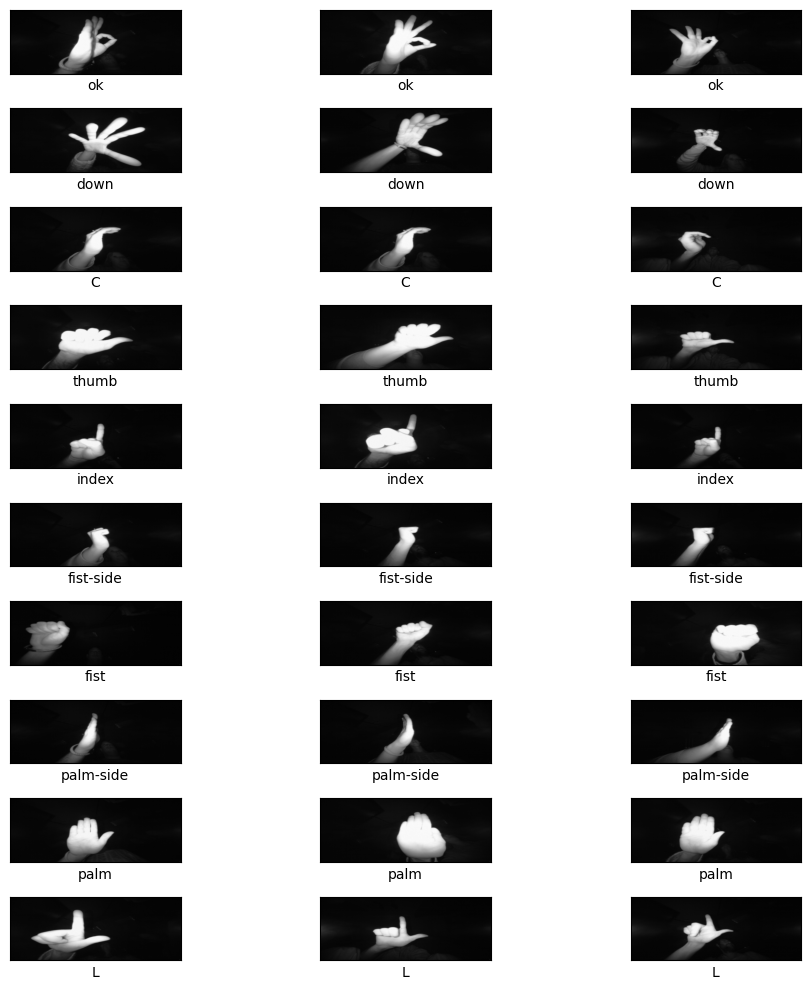

In [6]:
images_to_show = 3
fig, ax = plt.subplots(nrows = len(classes), ncols = images_to_show, figsize = (10,10))
for index, class_ in enumerate(classes):
    images = os.listdir(os.path.join(data, class_))
    for i, image in enumerate(images[:images_to_show]):
        img = cv2.imread(os.path.join(data, class_, image))
        ax[index, i].imshow(img)
        ax[index, i].set_xlabel(class_)
        ax[index, i].set_xticks([])
        ax[index, i].set_yticks([])

plt.tight_layout()
plt.show()

In [7]:
images = []
labels = []

for label in os.listdir(data):
    class_images = os.listdir(os.path.join(data, label))
    for image in class_images:
        images.append((os.path.join(data, label, image)))
        labels.append(label)

In [8]:
dataset = pd.DataFrame({'Images' : images, 'Labels' : labels})
dataset.head()

,Images,Labels
0,/kaggle/input/hand-signs-dataset/dataset/ok/fr...,ok
1,/kaggle/input/hand-signs-dataset/dataset/ok/fr...,ok
2,/kaggle/input/hand-signs-dataset/dataset/ok/fr...,ok
3,/kaggle/input/hand-signs-dataset/dataset/ok/fr...,ok
4,/kaggle/input/hand-signs-dataset/dataset/ok/fr...,ok


In [9]:
dataset['Labels'].value_counts()

Labels
ok           2000
down         2000
C            2000
thumb        2000
index        2000
fist-side    2000
fist         2000
palm-side    2000
palm         2000
L            2000
Name: count, dtype: int64

## `2. Splitting the Dataset`

In [10]:
X_train, X_val = train_test_split(dataset, test_size = 0.20, random_state = 123, stratify=dataset['Labels'])

In [11]:
X_train.head()

,Images,Labels
10394,/kaggle/input/hand-signs-dataset/dataset/fist-...,fist-side
13828,/kaggle/input/hand-signs-dataset/dataset/fist/...,fist
4566,/kaggle/input/hand-signs-dataset/dataset/C/fra...,C
2167,/kaggle/input/hand-signs-dataset/dataset/down/...,down
5478,/kaggle/input/hand-signs-dataset/dataset/C/fra...,C


In [12]:
X_train['Labels'].unique()

array(['fist-side', 'fist', 'C', 'down', 'L', 'palm-side', 'ok', 'thumb',
       'palm', 'index'], dtype=object)

In [13]:
X_val['Labels'].head()

13748     fist
8331     index
13530     fist
1103        ok
19470        L
Name: Labels, dtype: object

In [14]:
X_val['Labels'].unique()

array(['fist', 'index', 'ok', 'L', 'down', 'palm', 'thumb', 'palm-side',
       'C', 'fist-side'], dtype=object)

## `3. Data Augmentation`

In [15]:
train_gen = ImageDataGenerator(rescale= 1 / 255.0,
                             zoom_range = 0.5,
                             brightness_range=[0.2, 0.6],
                             rotation_range=20)

validation_gen = ImageDataGenerator(rescale = 1 / 255.0)

In [50]:
batch_size = 32

train_data = train_gen.flow_from_dataframe(dataframe=X_train,
                                           x_col="Images",
                                           y_col='Labels',
                                           classes = classes,
                                           target_size = (200,200),
                                           color_mode = 'grayscale',
                                           batch_size = batch_size,
                                           class_mode = 'sparse',
                                          shuffle = False)

valid_data = validation_gen.flow_from_dataframe(dataframe = X_val,
                                         x_col = 'Images',
                                         y_col = 'Labels',
                                        classes = classes,
                                        target_size = (200,200),
                                        color_mode = 'grayscale',
                                        batch_size = batch_size,
                                        class_mode = 'sparse', shuffle = False)

Found 16000 validated image filenames belonging to 10 classes.
Found 4000 validated image filenames belonging to 10 classes.


In [55]:
def assigned_labels(data):
    index = 1
    labels = list()
    for i in range(200):
        for image, label in zip(data[i][0], data[i][1]):
            if(len(labels) == 10): return
            if label not in labels: 
                labels.append(label)
            else:
                continue
            index+=1
            plt.imshow(image, cmap = 'gray')
            plt.title(f'{label} - {classes[int(label)]}')
            plt.tight_layout()
            plt.show()

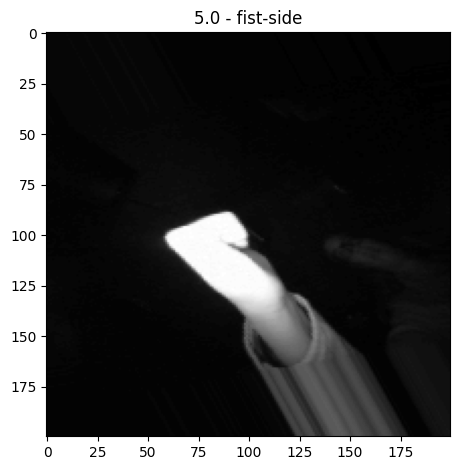

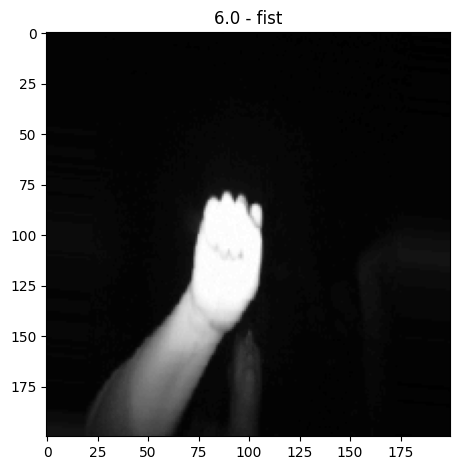

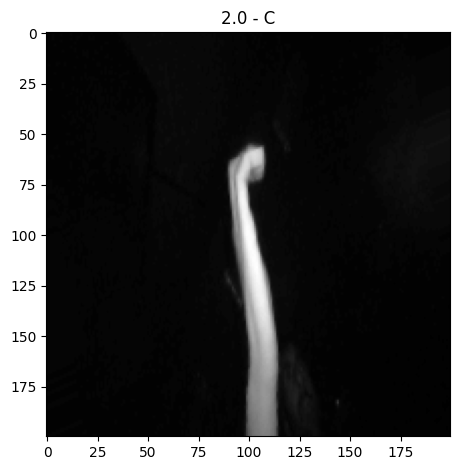

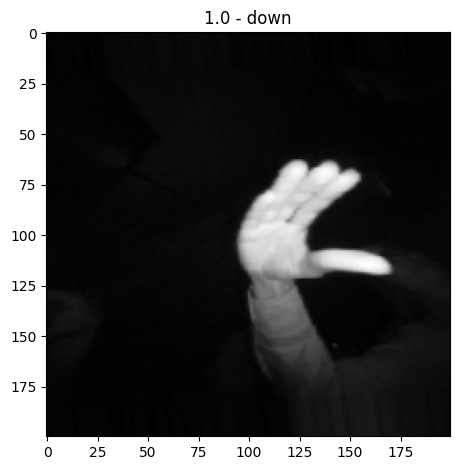

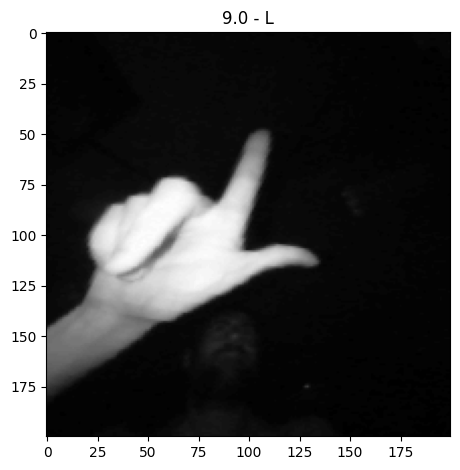

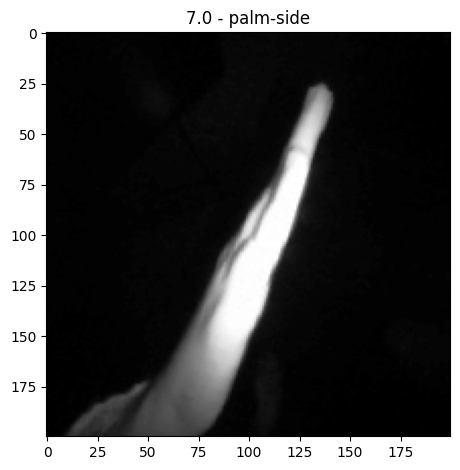

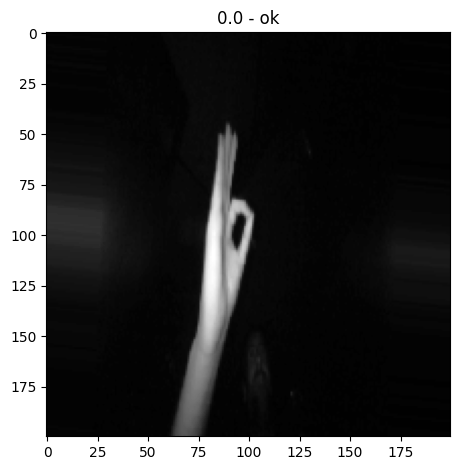

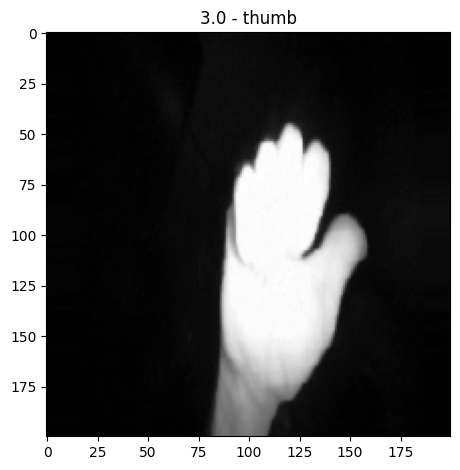

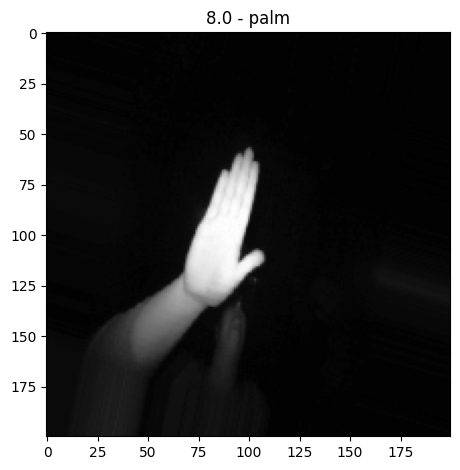

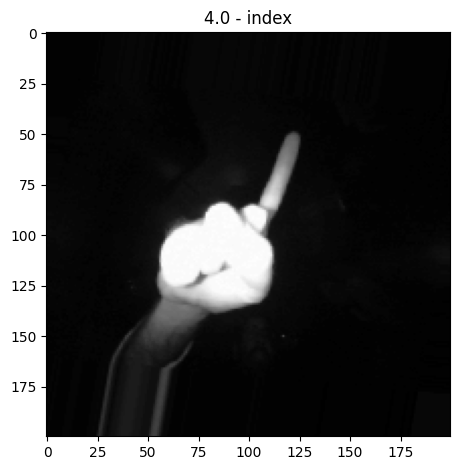

In [56]:
assigned_labels(train_data)

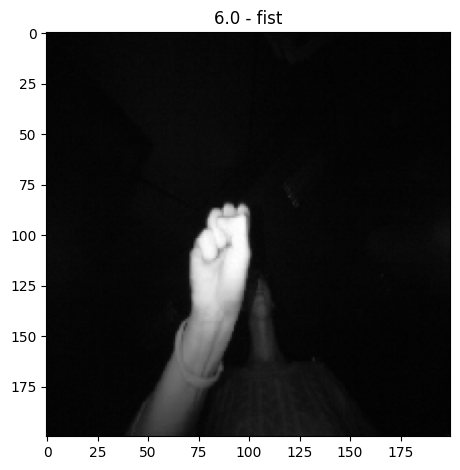

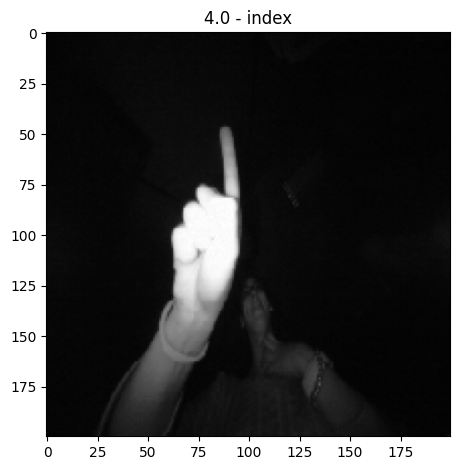

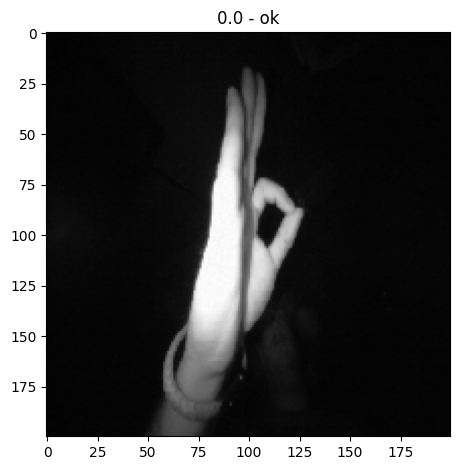

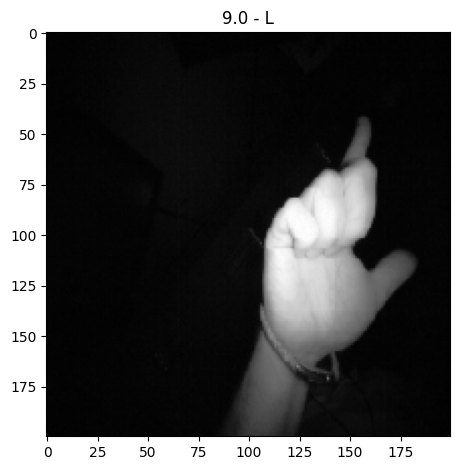

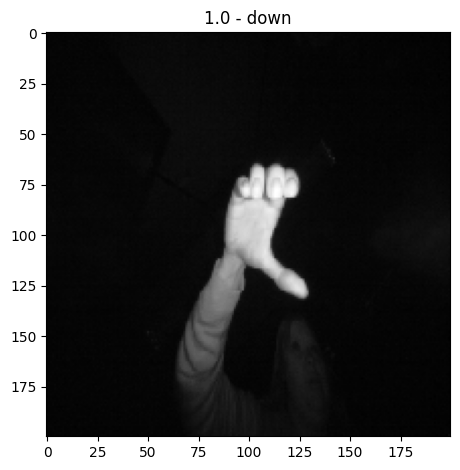

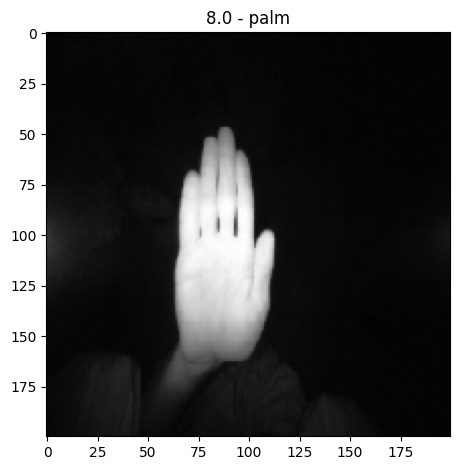

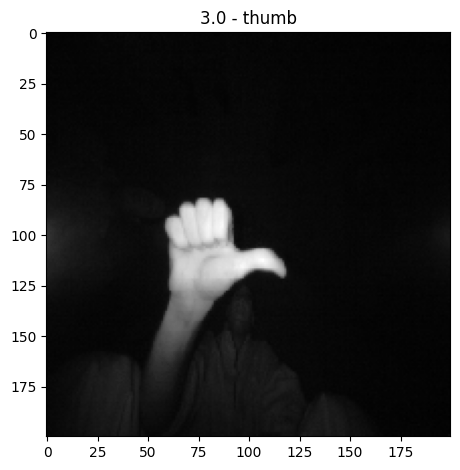

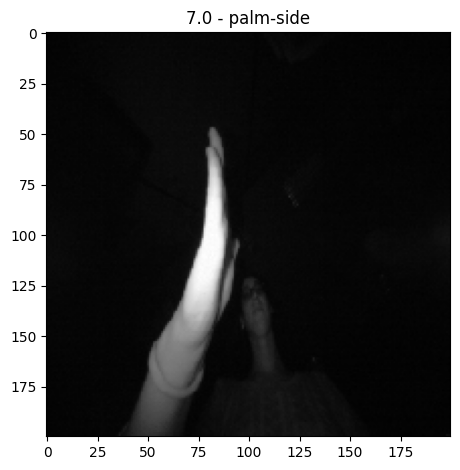

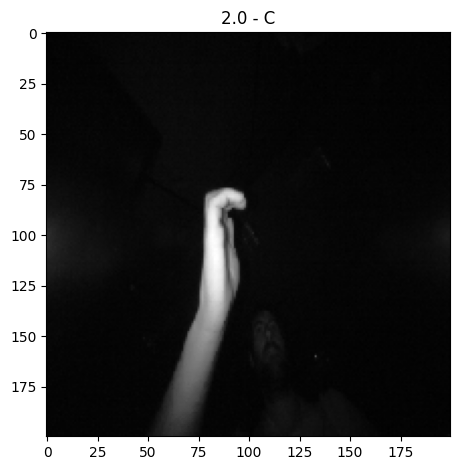

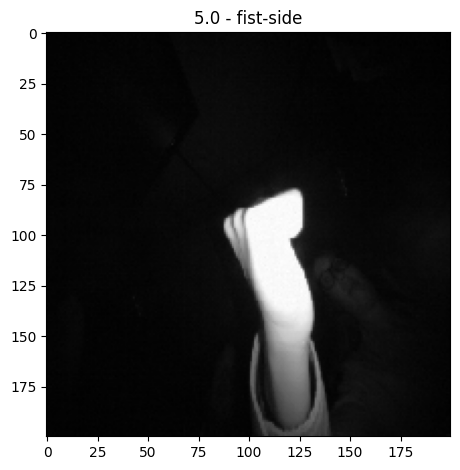

In [57]:
assigned_labels(valid_data)

In [58]:
model = Sequential([
    layers.Input(shape=(200, 200, 1)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 200, 200, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 200, 200, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 100, 100, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 100, 100, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 50, 50, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 25, 25, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,615,946 (17.61 MB)

 Trainable params: 4,612,618 (17.60 MB)

 Non-trainable params: 3,328 (13.00 KB)

In [59]:
model.compile(optimizer = keras.optimizers.SGD(learning_rate = 0.01),
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits = False),
              metrics = ['accuracy'])

In [60]:
modelCheckpoint = keras.callbacks.ModelCheckpoint(filepath = 'best_model.keras', monitor = 'val_loss', save_best_only = True, mode = 'min', verbose = 1)

In [61]:
train_model = model.fit(train_data,
                        epochs = 10,
                        validation_data = valid_data,
                        callbacks = [modelCheckpoint]
                       )

Epoch 1/10
  1/500 ━━━━━━━━━━━━━━━━━━━━ 1:14:22 9s/step - accuracy: 0.0625 - loss: 3.5099

W0000 00:00:1720435974.646379     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.5676 - loss: 1.3474

W0000 00:00:1720436109.358419     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 4.58682, saving model to best_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 165s 313ms/step - accuracy: 0.5680 - loss: 1.3462 - val_accuracy: 0.2010 - val_loss: 4.5868
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9359 - loss: 0.2065
Epoch 2: val_loss improved from 4.58682 to 0.36295, saving model to best_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 156s 308ms/step - accuracy: 0.9360 - loss: 0.2065 - val_accuracy: 0.8640 - val_loss: 0.3629
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9723 - loss: 0.0964
Epoch 3: val_loss improved from 0.36295 to 0.22210, saving model to best_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 201s 307ms/step - accuracy: 0.9723 - loss: 0.0964 - val_accuracy: 0.9208 - val_loss: 0.2221
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9789 - loss: 0.0721
Epoch 4: val_loss did not improve from 0.22210
500/500 ━━━━━━━━━━━━━━━━━━━━ 155s 306ms/step - accuracy: 0.9790 - loss: 0.

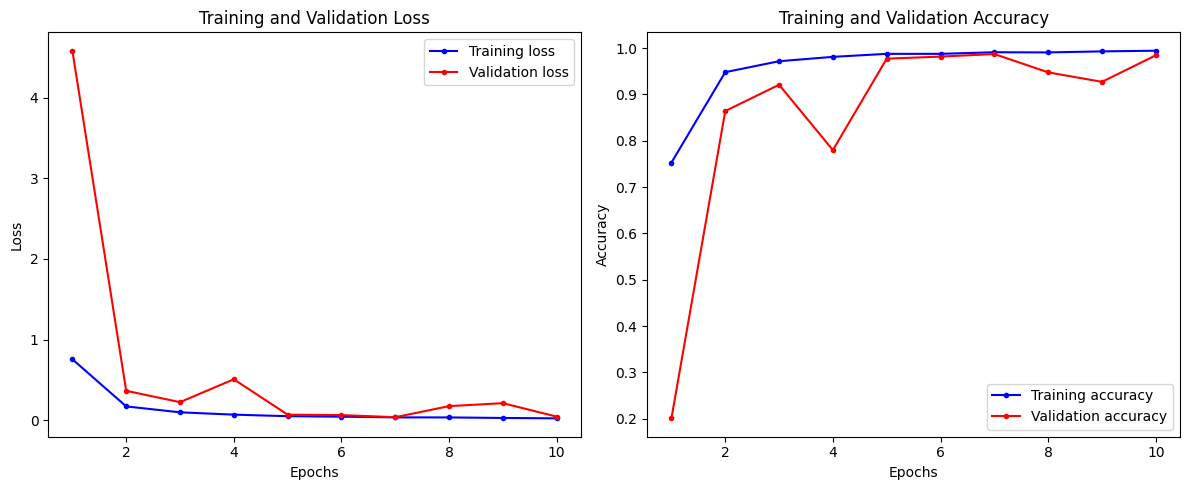

Accuracy -> 0.9941874742507935
Validation Accuracy -> 0.9869999885559082


In [62]:
history = train_model.history
epochs = range(1, len(history['loss']) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history['loss'], 'b.-', label='Training loss')
plt.plot(epochs, history['val_loss'], 'r.-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, history['accuracy'], 'b.-', label='Training accuracy')
plt.plot(epochs, history['val_accuracy'], 'r.-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print('Accuracy ->', max(train_model.history['accuracy']))
print('Validation Accuracy ->', max(train_model.history['val_accuracy']))

In [63]:
model.evaluate(valid_data)

125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 177ms/step - accuracy: 0.9852 - loss: 0.0394


[0.04222876578569412, 0.984250009059906]

In [64]:
pred = model.predict(valid_data)
pred = np.argmax(pred, axis=1)

labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

  3/125 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step  

W0000 00:00:1720437622.955741     142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 173ms/step


In [65]:
y_test =  [labels[class_] for class_ in valid_data.classes]

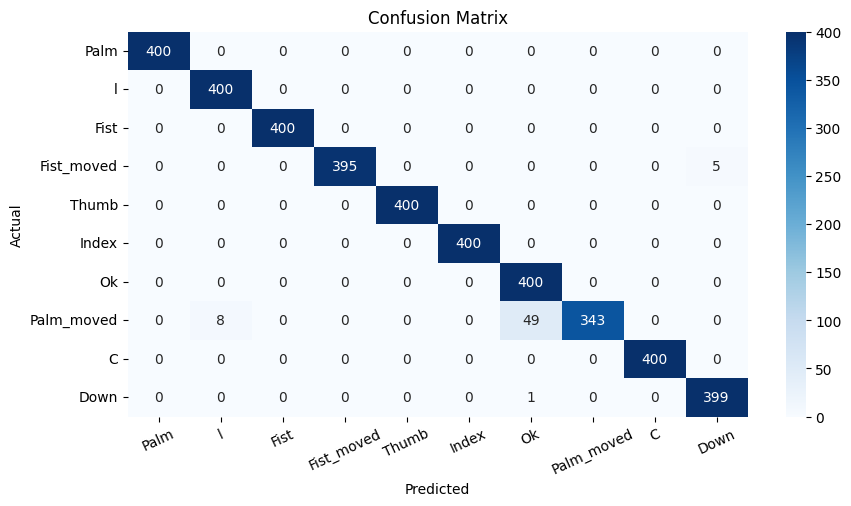

In [70]:
classes = ['Palm', 'l', 'Fist', 'Fist_moved', 'Thumb', 'Index', 'Ok', 'Palm_moved', 'C', 'Down']

cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5], labels=classes, rotation=25)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5], labels=classes, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

## `Exporting the model`

In [72]:
model.save('/kaggle/working/my_model.h5')